In [1]:
import gammapy
print(gammapy.__version__ , " == 1")

0.1.dev19174+g56b5bdf  == 1


In [2]:
import numpy as np
import os
import astropy
from astropy import units as u
from collections import OrderedDict
from astropy import units
from gammapy.data import DataStore
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, DataStore
from astropy.coordinates import SkyOffsetFrame
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.datasets import MapDataset
from gammapy.irf import load_cta_irfs, EDispKernel, PSFKernel
from gammapy.modeling import Fit

from gammapy.modeling.models import (
    Models,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion, RectangleSkyRegion


In [3]:
# define some functions for the geometry
def get_ebins():
    min_energy = 0
    ebins = np.logspace(-1,2,25)
    e_edges = ebins.copy()[np.where(ebins>=min_energy)[0][0]:]
    return e_edges*u.TeV

def get_geom():    

    geom_set = dict(
            width = (lon_width * u.deg, lat_width * u.deg),
            pix_size = pix_size * u.deg,
            e_edges  = get_ebins(),
            sky_dir = pks_pos,
            frame = 'icrs'
        )

    eaxis = MapAxis.from_edges(geom_set['e_edges'], name='energy', interp='log')

    geom = WcsGeom.create(
        skydir=geom_set['sky_dir'],
        binsz=geom_set['pix_size'],
        width=geom_set['width'],
        frame=geom_set['frame'],
        proj='CAR',
        axes=[eaxis],
    )

    geom_2d = geom.slice_by_idx(dict(energy=1))

    return geom, geom_2d



## Reading and peeking into the Datastore
The data is the HESS public PKS2155 steady runs. 
See info https://www.mpi-hd.mpg.de/HESS/pages/dl3-dr1/hess_dl3_dr1.pdf

In [4]:

#copied from /home/wecapstor1/caph/shared/hess/fits/fits_data/fits_paper_data.tar.gz
path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_flare/out'
path_saving = os.getcwd() 
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
hdul = fits.open(f"{path}/obs-index-bg-v05-fov-radec.fits.gz")
try:
    # File with all the obs ids to analyse
    obsid = 'obsid.txt'
    obsid = np.loadtxt(obsid)
except:
    string = ''
    for o in data_store.obs_ids:
        string += str(o) + '\n'
    print(string)
    with open('obsid.txt', 'w') as f:
        f.write(string)
    obsid = 'obsid.txt'
    obsid = np.loadtxt(obsid)




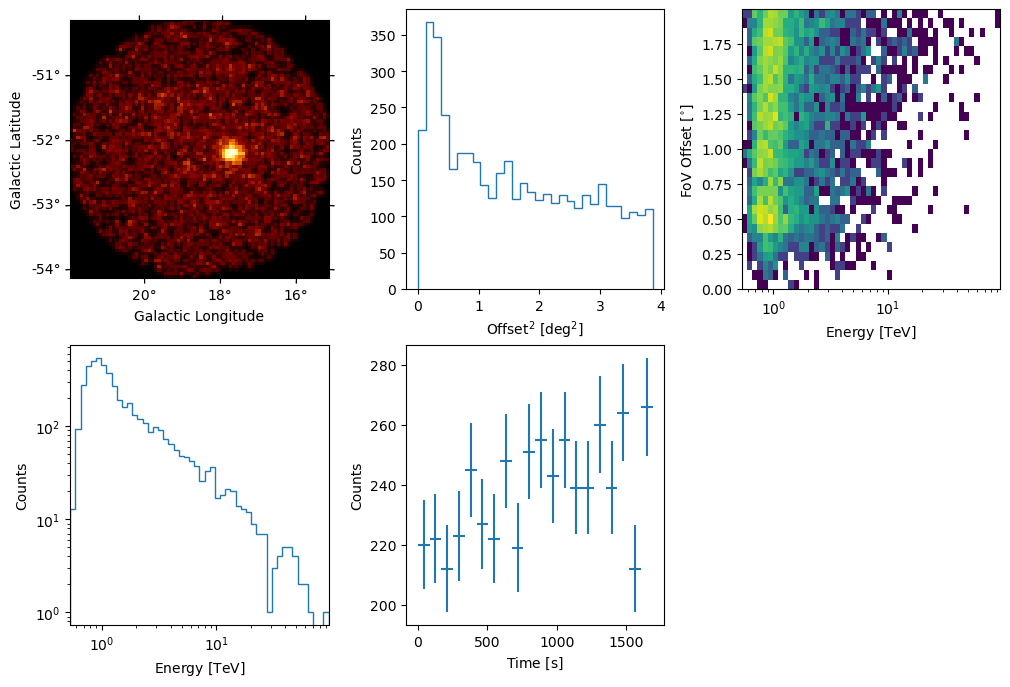

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


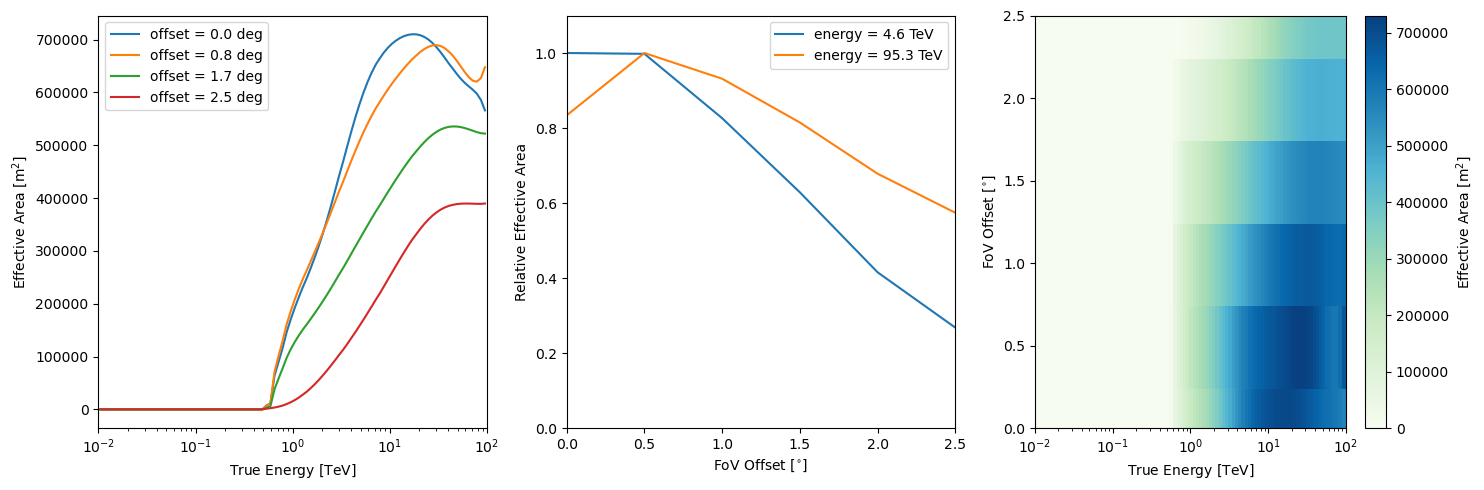

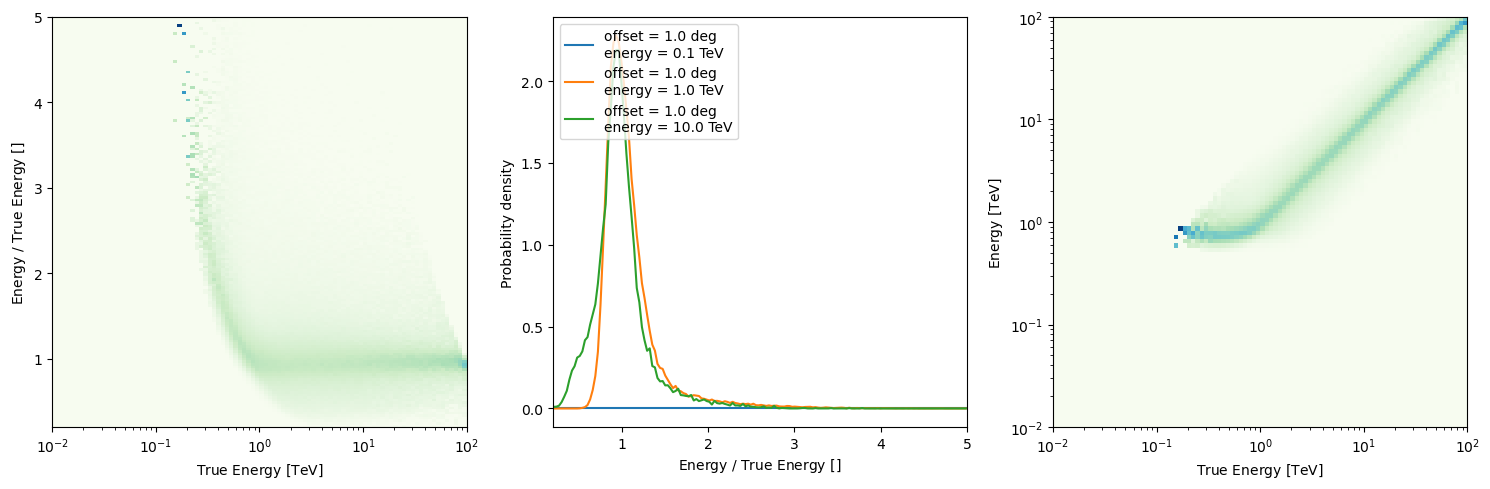

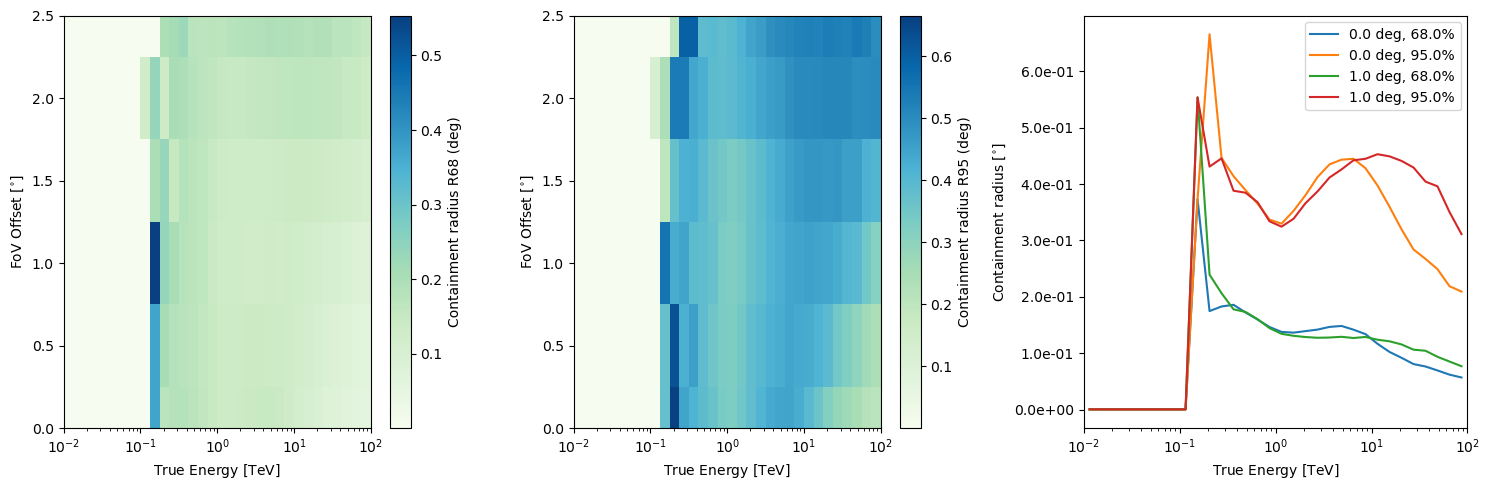

Missing 'HDUCLAS2' keyword assuming 'BKG'


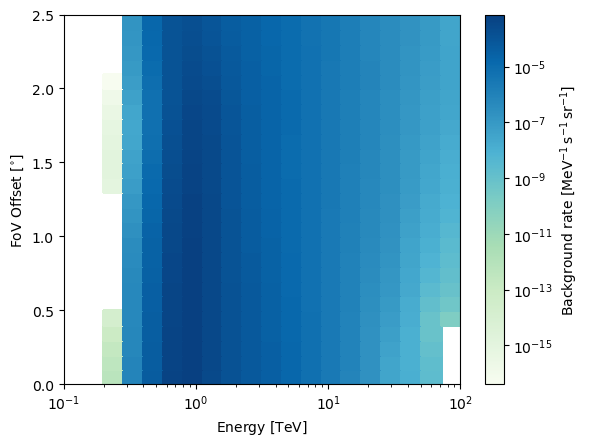

In [5]:
## looking at observation 0 as an example
import matplotlib.pyplot as plt

obs = data_store.obs(obsid[0])
obs.events.select_offset([0, 2] * u.deg).peek()
plt.show()

obs.aeff.peek()
plt.show()

obs.edisp.peek()
plt.show()

obs.psf.peek()
plt.show()

obs.bkg.to_2d().plot()
plt.show()

In [6]:
obs.pointing_altaz.alt.deg

/tmp/ipykernel_1349952/4067797714.py:1: GammapyDeprecationWarning: Use observation.get_pointing_altaz(time) instead
  obs.pointing_altaz.alt.deg
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The altaz function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/pointing.py:522: GammapyDeprecationWarning: The location function is deprecated and may be removed in a future version.
  frame = AltAz(location=self.location, obstime=self.obstime)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecatio

39.6734754603293

In [7]:
# some info 
ontime=[]
livetime=[]
date=[]
angle=[]
observations = data_store.get_observations(obsid)
for obs in observations:
    livetime.append(obs.observation_live_time_duration.value)
    ontime.append(obs.observation_time_duration)
    date.append(obs.tmid)
    angle.append(90 - obs.get_pointing_altaz(obs.tmid).alt.deg)
livetime=np.array(livetime)
print(f'runs: {len(observations)}')
print(f'livetime: {np.sum(livetime)/3600:.3} hr')
print('date:','{}-{}'.format(min(date),max(date)))
print(f'avg zenith: {np.mean(angle):.3} pm {np.std(angle):.3} deg')
print(f'min zenith: {np.min(angle):.3} deg')

#print('duration:',timeobs/60)

runs: 15
livetime: 7.04 hr
date: 53945.86091069444-53946.16231115741
avg zenith: 27.7 pm 13.6 deg
min zenith: 7.48 deg


Text(0.5, 0, 'Zenith [Deg]')

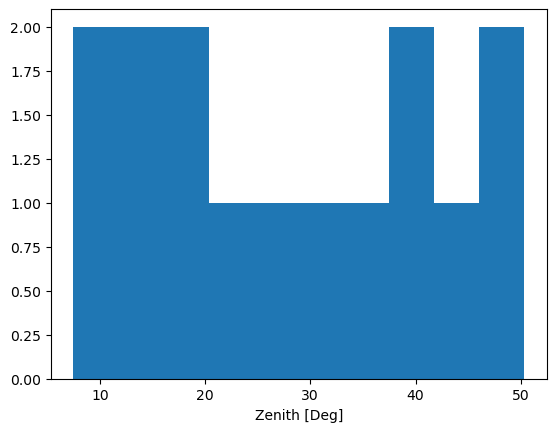

In [8]:
plt.hist(angle)
plt.xlabel('Zenith [Deg]')

In [9]:
# setting the position of the source
pks_pos = SkyCoord("21h58m43.2s", "-30d13m18s")
pks_pos = SkyCoord(frame = "galactic",l =  "17.74 deg", b= "-52.25 deg")
print(pks_pos)

<SkyCoord (Galactic): (l, b) in deg
    (17.74, -52.25)>


## 2. Computing the Energy Threshold
We want to analyse the data only above a certain energy threshold for which we are sure to have reconstructed the data well.

There are two criteria: 
1. The energy bias is smaller than 10 % (stored in ``threshold.txt``)
2. The background rate is smaller than the peak value. (stored in ``bkgthreshold.txt``)

In the end we will use the maximum value of those. 



### 2.1. Energy Bias < 10 % Threshold

In [10]:
# define txt files in which the two different thresholds are written into
store_threshold = 'threshold.txt'
store_bgthreshold = 'bkg_threshold.txt'

source = 'PKS'
config = 'std_ImPACT_fullEnclosure'
max_offset = 2.0 
min_energy = 0
ebins = get_ebins()
energy_binning = ebins.copy()[np.where(ebins>=min_energy)[0][0]:] #ebins.copy()[np.where(ebins>=min_energy)[0][0]-1:]





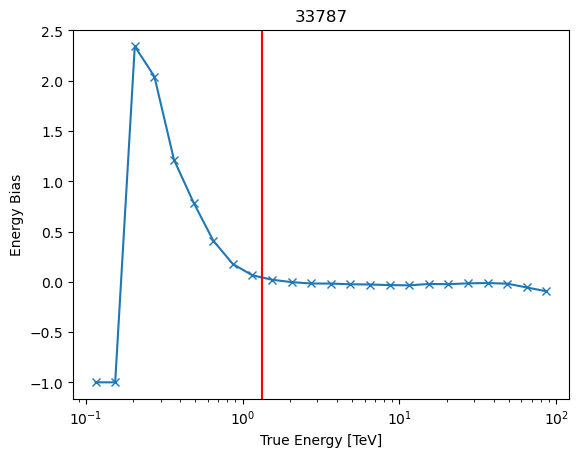

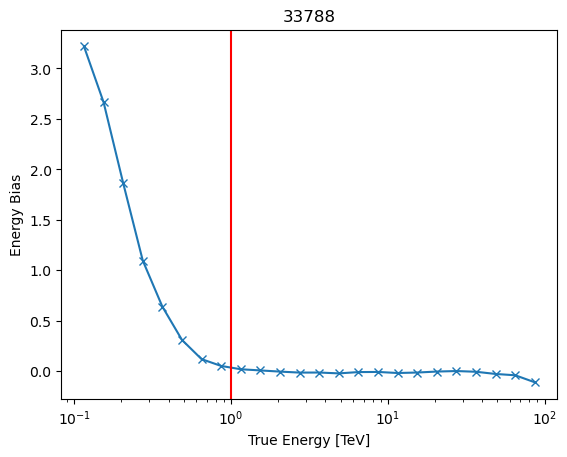

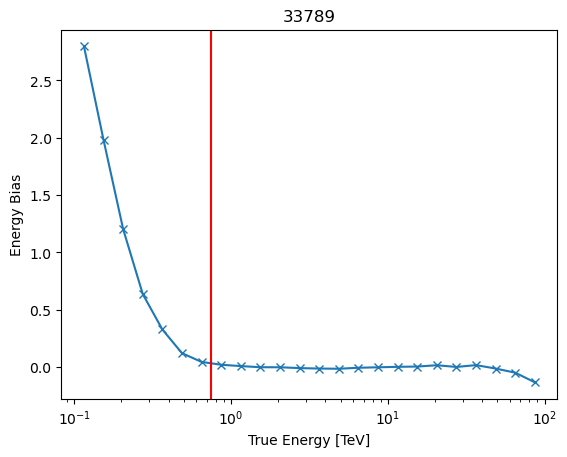

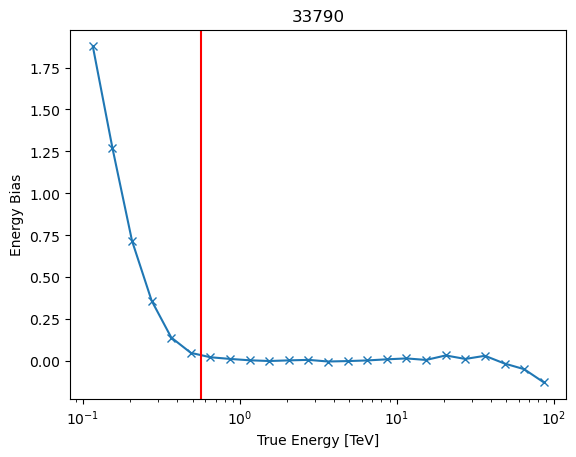

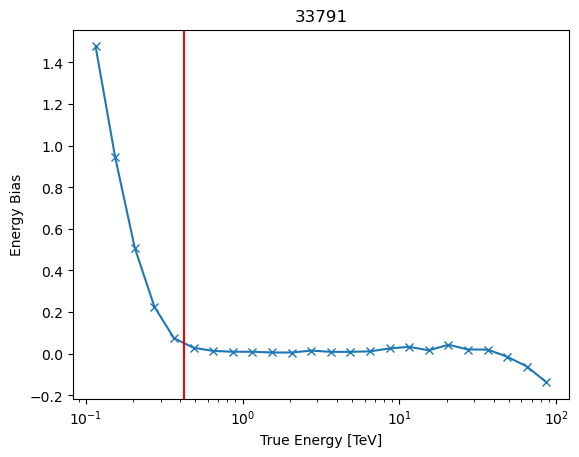

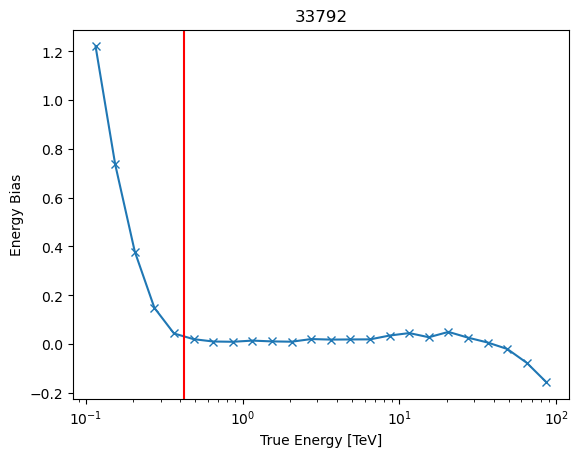

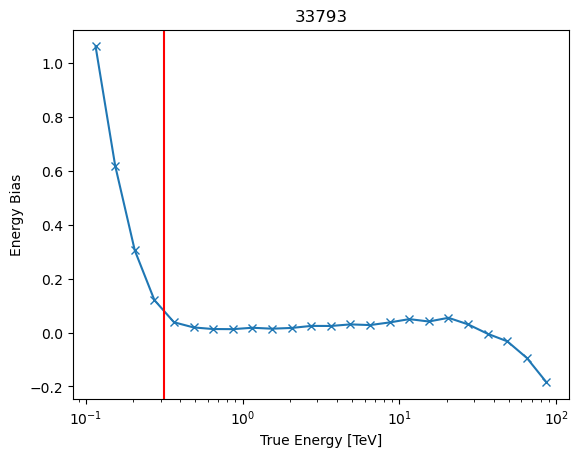

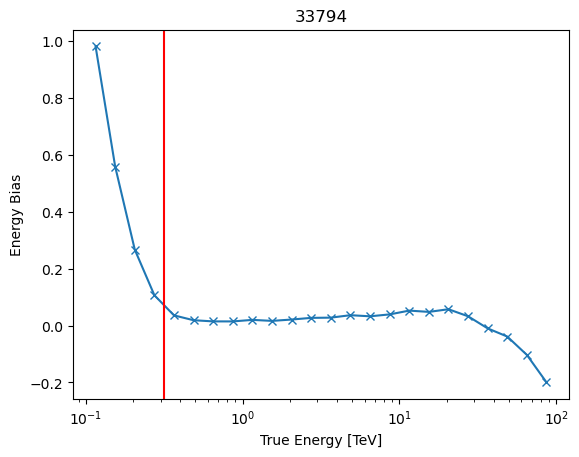

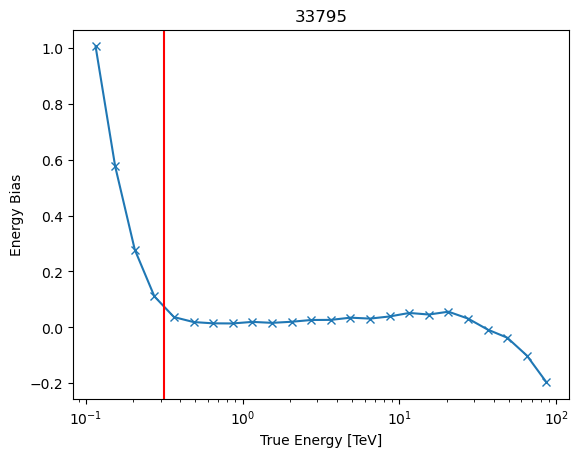

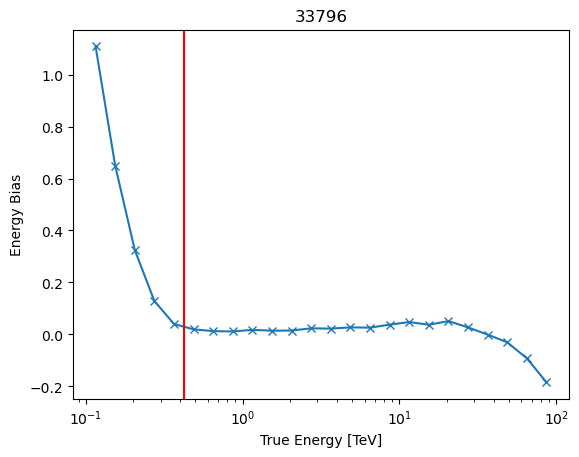

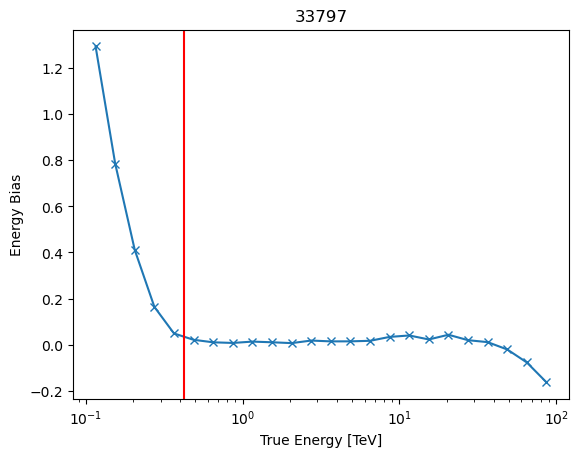

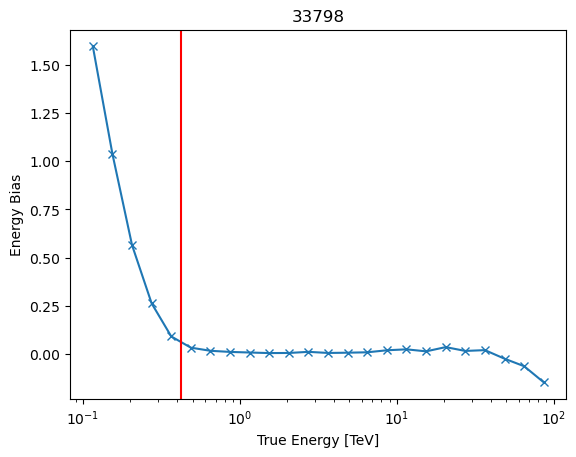

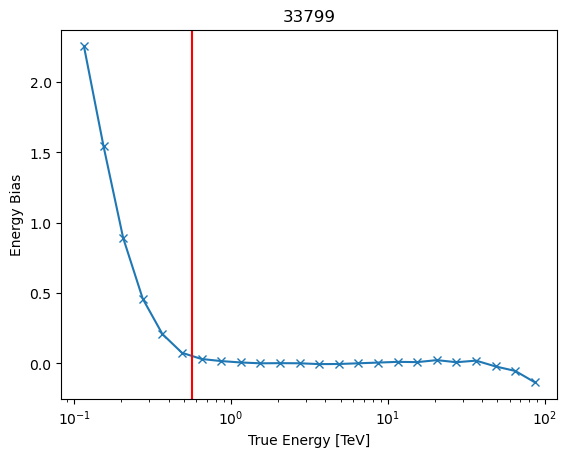

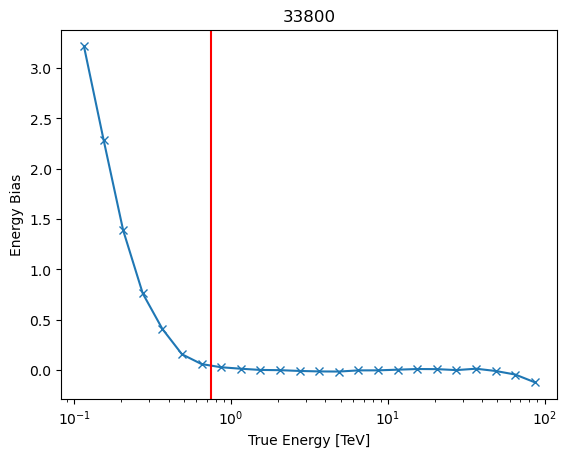

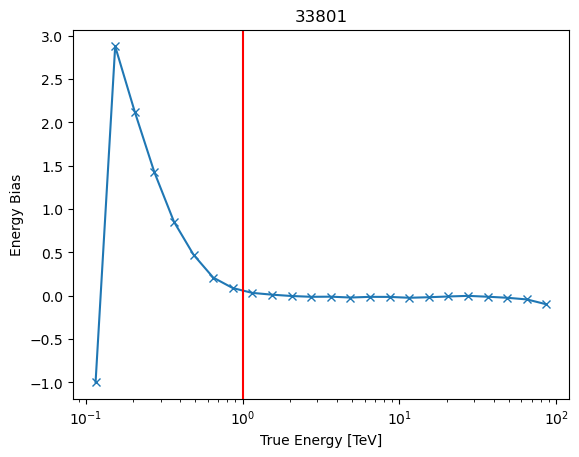

In [11]:

emax=10*units.TeV
# open file to print into
with open(store_threshold, 'w') as f:

    for obs in observations:
        thr_offset = max_offset * units.deg

        # extract energy dispersion for maximum offset
        edisp = obs.edisp.to_edisp_kernel(thr_offset, energy=energy_binning, energy_true=energy_binning)
        e_true = edisp.axes['energy_true'].center
        values = edisp.get_bias(e_true)
        plt.figure()
        # determine threshold from energy dispersion
        threshold = edisp.get_bias_energy(0.1,energy_min=e_true[np.nanargmax(values)],energy_max=emax)[0]
        if e_true[np.nanargmax(values)]>emax:
            threshold = edisp.get_bias_energy(0.1,energy_min=e_true[np.nanargmax(values[0:20])],energy_max=emax)[0]

        # use lower edge of first bin above threshold
        threshold = energy_binning[np.where(~(energy_binning.value[:-1]<threshold.value))[0][0]]

        threshold = np.floor(1e4*threshold)/1e4
        #print to file
        print(obs.obs_id, '  {:.4f}'.format(threshold.value),  file=f)
        print('')

        #if threshold.value>1:
        import matplotlib.pyplot as plt
        plt.plot(e_true,values, 'x-')
        plt.axvline(x=threshold.value,color='r', )
        plt.xscale('log')
        #plt.yscale('log')
        plt.xlabel("True Energy [TeV]")
        plt.ylabel("Energy Bias")
        plt.title(obs.obs_id)
        plt.show()



### 2.2. Background Peak Threshold



/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


t  33787


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 1.0715 TeV
    max rate of 3614.38 1 / TeV in bin 7, upper edge 1.0000 TeV TeV
t  33788


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.7079 TeV
    max rate of 5702.80 1 / TeV in bin 6, upper edge 0.7498 TeV TeV
t  33789


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.5370 TeV
    max rate of 9067.50 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  33790


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4074 TeV
    max rate of 13163.70 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  33791


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3311 TeV
    max rate of 15541.69 1 / TeV in bin 3, upper edge 0.3162 TeV TeV
t  33792


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3090 TeV
    max rate of 20906.80 1 / TeV in bin 3, upper edge 0.3162 TeV TeV
t  33793


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.2884 TeV
    max rate of 22665.65 1 / TeV in bin 3, upper edge 0.3162 TeV TeV
t  33794


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.2512 TeV
    max rate of 23018.06 1 / TeV in bin 3, upper edge 0.3162 TeV TeV
t  33795


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.2512 TeV
    max rate of 23082.93 1 / TeV in bin 3, upper edge 0.3162 TeV TeV
t  33796


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.2884 TeV
    max rate of 22702.70 1 / TeV in bin 3, upper edge 0.3162 TeV TeV
t  33797


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3090 TeV
    max rate of 18710.57 1 / TeV in bin 3, upper edge 0.3162 TeV TeV
t  33798


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 14523.23 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  33799


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4365 TeV
    max rate of 11288.84 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  33800


/tmp/ipykernel_1349952/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.5370 TeV
    max rate of 8011.11 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  33801
    threshold from aeff fits file is 0.8128 TeV
    max rate of 4409.93 1 / TeV in bin 6, upper edge 0.7498 TeV TeV


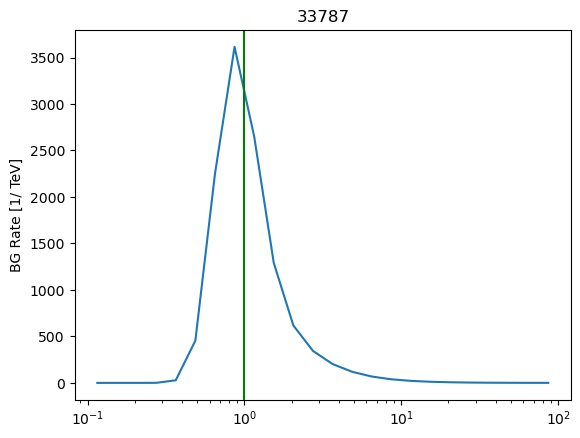

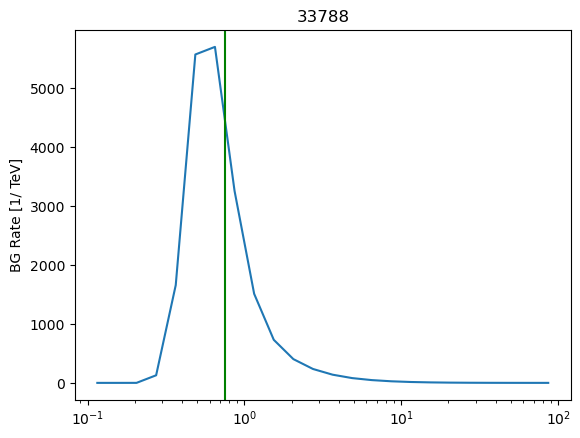

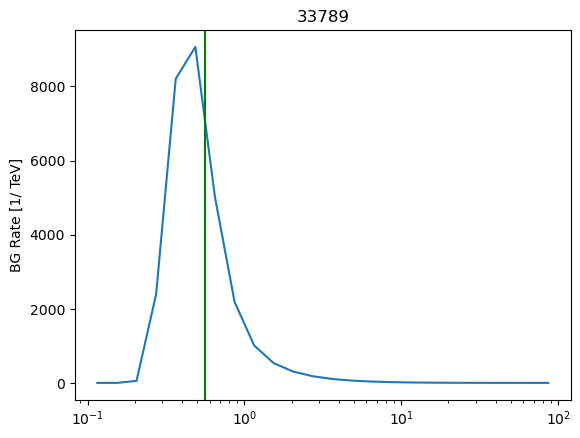

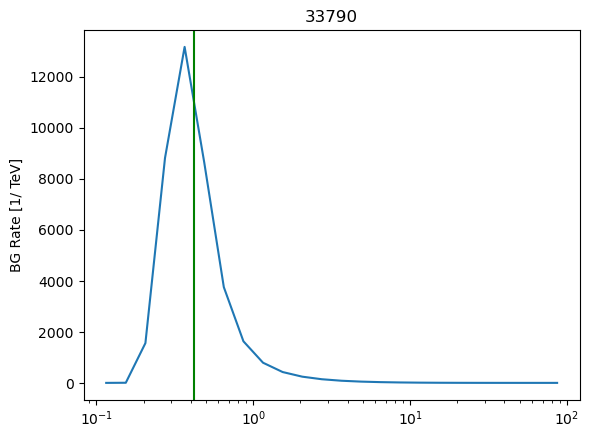

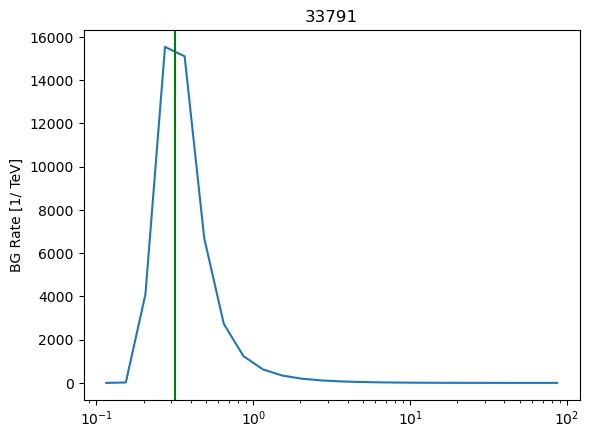

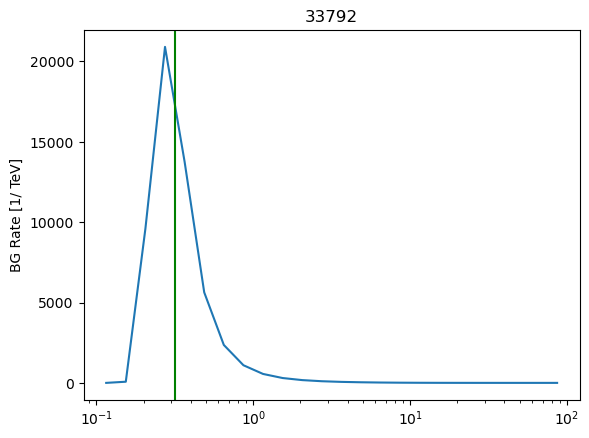

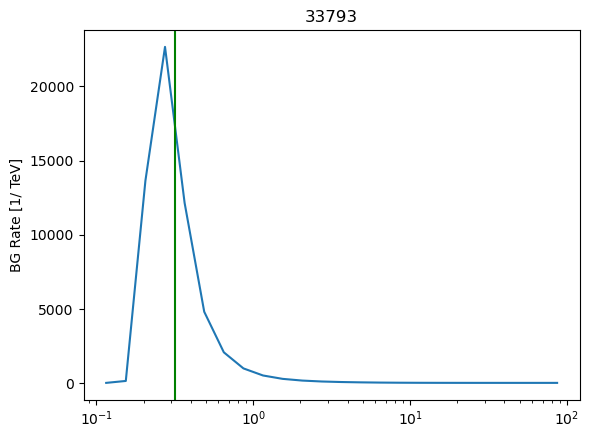

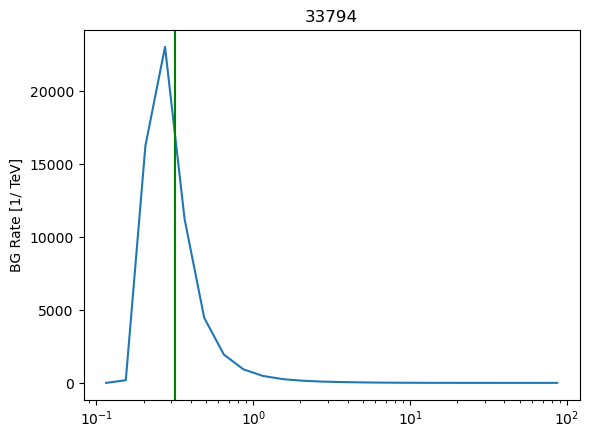

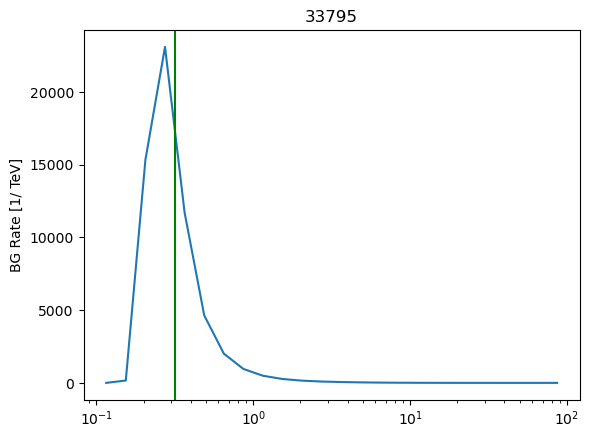

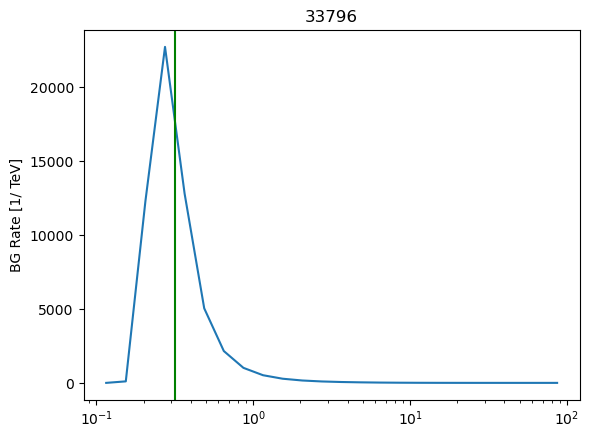

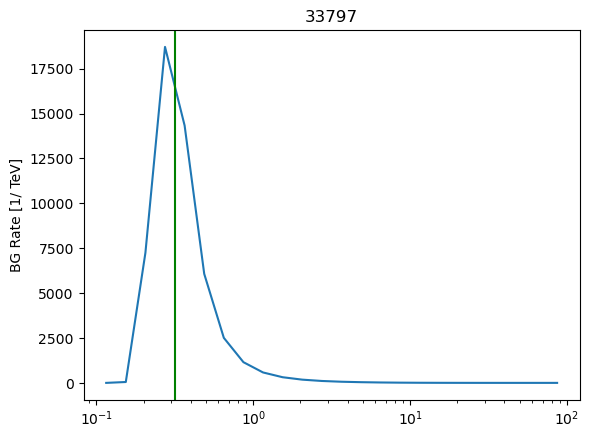

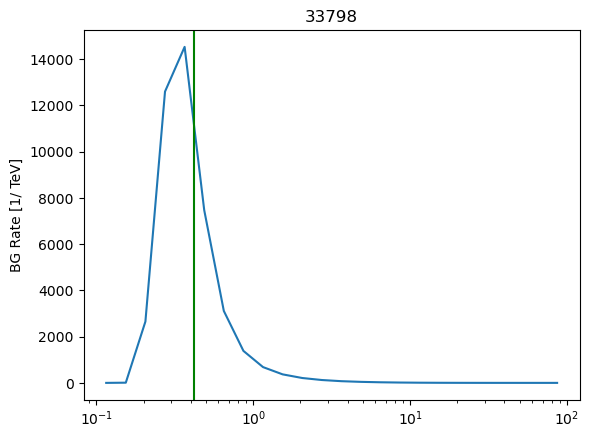

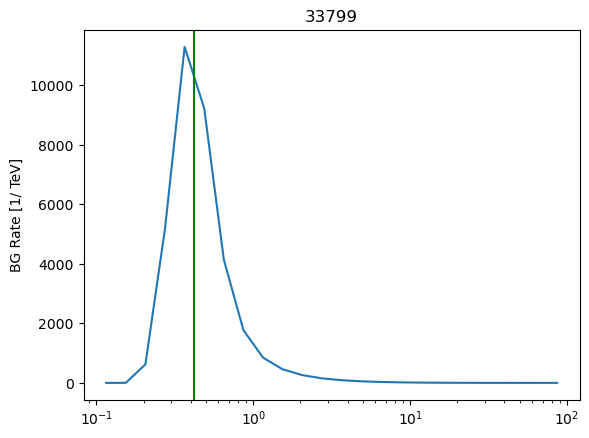

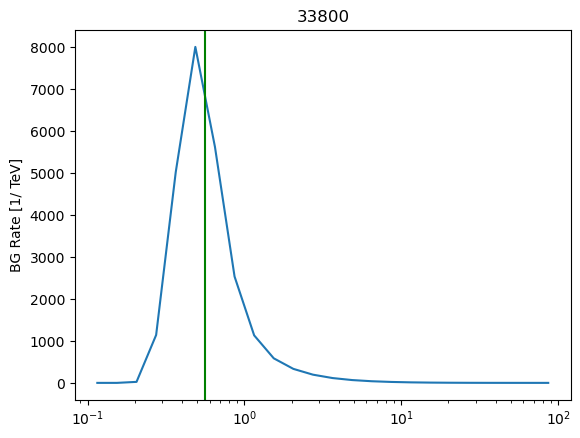

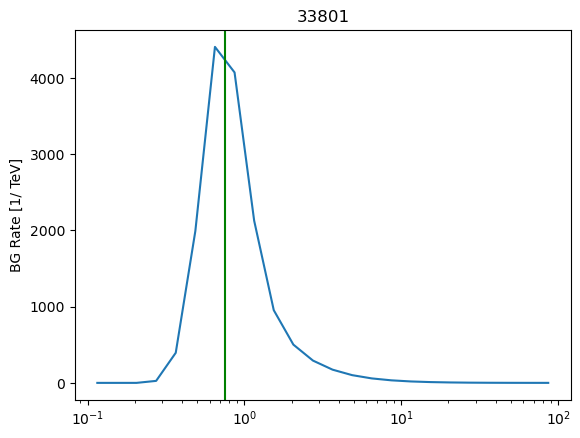

In [12]:

maker = MapDatasetMaker(background_oversampling=2, selection=['background'])
bgmodel_version = 'v08c'


min_energies = {}

# open file to print into
with open(store_bgthreshold, 'w') as f:

    ra_pnt = data_store.obs_table['RA_PNT']
    dec_pnt = data_store.obs_table['DEC_PNT']

    min_energies[source] = OrderedDict()

    for j in range(len(observations)):
        obs = observations[j]
        print('t ', obs.obs_id)
        e_thres = obs.aeff.meta['LO_THRES']
        eaxis = MapAxis.from_edges(get_ebins(), unit='TeV', name='energy', interp='log')

        geom = WcsGeom.create(
            skydir=obs.pointing_radec,
            binsz=0.02,
            width=(4.3, 4.3),
            frame='icrs',
            proj='CAR',
            axes=[eaxis],
        )
        bg_map = maker.make_background(geom, obs)


        bg_rate = bg_map.data.sum(axis=(1,2)) / np.diff(eaxis.edges)
        plt.figure()
        plt.plot(eaxis.center.value, bg_rate)
        plt.ylabel('BG Rate [1/ TeV]')
        plt.xscale('log')
        plt.title(obs.obs_id)
        
        print('    threshold from aeff fits file is {:.4f} TeV'.format(e_thres))
         # print to file
        print(obs.obs_id, '  {:.4f}'.format(e_thres), file=f)
        emin = eaxis.edges[1:][np.argmax(bg_rate)]
        emin = np.floor(1e4*emin)/1e4
        plt.axvline(x=emin.value,color='green', )
        
        print('    max rate of {:.2f} in bin {:d}, upper edge {:.4f} TeV'.format(np.max(bg_rate), np.argmax(bg_rate), emin))
        
        min_energies[source][obs.obs_id] = emin


## Compare Thresholds

In [13]:
thres_list = "threshold.txt"
thresholds = np.loadtxt(thres_list)
bgthres_list = "bkg_threshold.txt"
bgthresholds = np.loadtxt(bgthres_list)
#pick the one with max value
maxthreshold = np.array(list(map(max, zip(thresholds[:,1], bgthresholds[:,1]))))


In [14]:
np.min(maxthreshold)

0.3162

In [15]:
len(angle)

15

In [16]:
print(np.min(angle), np.max(angle))


7.4772171371828335 50.3265245396707


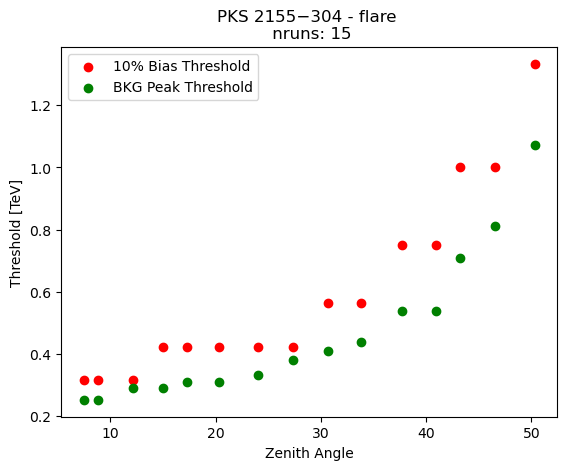

In [17]:
plt.scatter(angle,thresholds[:,1], label  = "10% Bias Threshold", color = 'r')
plt.scatter(angle,bgthresholds[:,1],label  = "BKG Peak Threshold", color = 'green')
plt.legend()
plt.xlabel("Zenith Angle")
plt.ylabel("Threshold [TeV]")
plt.title(f"PKS 2155−304 - flare \n nruns: {len(observations)}")
fig = plt.gcf()
fig.savefig("plots/1-thresholds_zenith.png")

## 3. Run-wise BKG Fitting and Dataset Creation

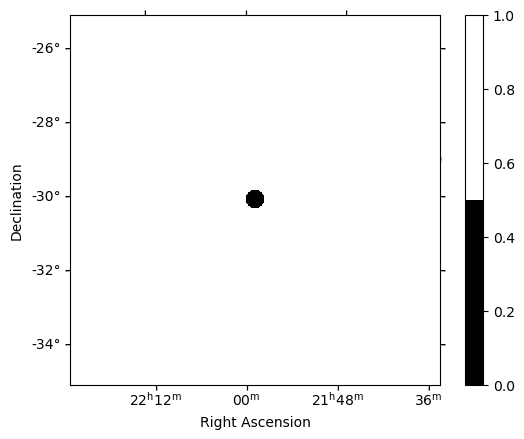

In [18]:
# define exclusion region around the source
excl_regions = []
lon_width,lat_width,pix_size = 10,10,0.02
radius = 0.25*u.deg
skyregion = CircleSkyRegion(center=pks_pos, radius=radius)
excl_regions = [skyregion]
excl_mask_2d = Map.from_geom(get_geom()[1], data=get_geom()[1].region_mask(excl_regions, inside=False).data)
excl_mask_2d.plot(add_cbar = 1, vmin =0, vmax = 1);

/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : 8ZA8QLpO 

  Total counts                    : 1696 
  Total background counts         : 1561.36
  Total excess counts             : 134.64

  Predicted counts                : 1696.27
  Predicted background counts     : 1696.27
  Predicted excess counts         : 0.00

  Exposure min                    : 4.13e+07 m2 s
  Exposure max                    : 1.23e+09 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 462568 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20304.75

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : 8ZA8QLpO-bkg
    Datasets names            : ['8ZA8QLpO']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.022   +/-    0.04             

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : ii5P8T1M 

  Total counts                    : 1406 
  Total background counts         : 1376.65
  Total excess counts             : 29.35

  Predicted counts                : 1405.88
  Predicted background counts     : 1405.88
  Predicted excess counts         : 0.00

  Exposure min                    : 4.81e+06 m2 s
  Exposure max                    : 9.06e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 493757 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17282.99

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : ii5P8T1M-bkg
    Datasets names            : ['ii5P8T1M']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.018   +/-    0.04             


/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : XPzbdp2I 

  Total counts                    : 1593 
  Total background counts         : 1415.34
  Total excess counts             : 177.66

  Predicted counts                : 1592.91
  Predicted background counts     : 1592.91
  Predicted excess counts         : 0.00

  Exposure min                    : 5.52e+06 m2 s
  Exposure max                    : 7.18e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 524753 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19188.97

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : XPzbdp2I-bkg
    Datasets names            : ['XPzbdp2I']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.100   +/-    0.03             

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : OK9GBZc1 

  Total counts                    : 1636 
  Total background counts         : 1667.34
  Total excess counts             : -31.34

  Predicted counts                : 1635.96
  Predicted background counts     : 1635.96
  Predicted excess counts         : 0.00

  Exposure min                    : 1.73e+07 m2 s
  Exposure max                    : 5.80e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 556559 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19456.72

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : OK9GBZc1-bkg
    Datasets names            : ['OK9GBZc1']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.972   +/-    0.03             

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : Lxqwp6DZ 

  Total counts                    : 2068 
  Total background counts         : 2042.50
  Total excess counts             : 25.50

  Predicted counts                : 2068.01
  Predicted background counts     : 2068.01
  Predicted excess counts         : 0.00

  Exposure min                    : 6.52e+06 m2 s
  Exposure max                    : 4.81e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 587699 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 23331.80

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : Lxqwp6DZ-bkg
    Datasets names            : ['Lxqwp6DZ']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.020   +/-    0.02             


/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : ji8vgpwm 

  Total counts                    : 1733 
  Total background counts         : 1759.13
  Total excess counts             : -26.13

  Predicted counts                : 1732.99
  Predicted background counts     : 1732.99
  Predicted excess counts         : 0.00

  Exposure min                    : 1.17e+07 m2 s
  Exposure max                    : 4.26e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 587664 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20049.54

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : ji8vgpwm-bkg
    Datasets names            : ['ji8vgpwm']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.985   +/-    0.02             

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : 8UMGFlbk 

  Total counts                    : 2721 
  Total background counts         : 2636.38
  Total excess counts             : 84.62

  Predicted counts                : 2720.97
  Predicted background counts     : 2720.97
  Predicted excess counts         : 0.00

  Exposure min                    : 1.47e+07 m2 s
  Exposure max                    : 3.97e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 618660 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 28476.95

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : 8UMGFlbk-bkg
    Datasets names            : ['8UMGFlbk']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.042   +/-    0.02             


/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : PiSbjTyi 

  Total counts                    : 2585 
  Total background counts         : 2460.98
  Total excess counts             : 124.02

  Predicted counts                : 2585.04
  Predicted background counts     : 2585.04
  Predicted excess counts         : 0.00

  Exposure min                    : 1.62e+07 m2 s
  Exposure max                    : 3.81e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 618680 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 27566.95

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : PiSbjTyi-bkg
    Datasets names            : ['PiSbjTyi']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.076   +/-    0.02             

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : X9mfYNg6 

  Total counts                    : 2527 
  Total background counts         : 2552.76
  Total excess counts             : -25.76

  Predicted counts                : 2526.98
  Predicted background counts     : 2526.98
  Predicted excess counts         : 0.00

  Exposure min                    : 1.57e+07 m2 s
  Exposure max                    : 3.85e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 618705 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26853.51

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : X9mfYNg6-bkg
    Datasets names            : ['X9mfYNg6']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.992   +/-    0.02             

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : i_FrPaB7 

  Total counts                    : 1676 
  Total background counts         : 1599.61
  Total excess counts             : 76.39

  Predicted counts                : 1676.00
  Predicted background counts     : 1676.00
  Predicted excess counts         : 0.00

  Exposure min                    : 1.38e+07 m2 s
  Exposure max                    : 4.07e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 587682 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19703.96

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : i_FrPaB7-bkg
    Datasets names            : ['i_FrPaB7']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.051   +/-    0.03             


/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : mXViBX5U 

  Total counts                    : 1800 
  Total background counts         : 1875.85
  Total excess counts             : -75.85

  Predicted counts                : 1799.91
  Predicted background counts     : 1799.91
  Predicted excess counts         : 0.00

  Exposure min                    : 1.04e+07 m2 s
  Exposure max                    : 4.45e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 587675 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20700.29

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : mXViBX5U-bkg
    Datasets names            : ['mXViBX5U']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.961   +/-    0.02             

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : sLrPb308 

  Total counts                    : 2216 
  Total background counts         : 2298.10
  Total excess counts             : -82.10

  Predicted counts                : 2215.98
  Predicted background counts     : 2215.98
  Predicted excess counts         : 0.00

  Exposure min                    : 3.64e+06 m2 s
  Exposure max                    : 5.12e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 587600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24523.82

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : sLrPb308-bkg
    Datasets names            : ['sLrPb308']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.968   +/-    0.02             

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : dJ9z5bUC 

  Total counts                    : 1828 
  Total background counts         : 1823.98
  Total excess counts             : 4.02

  Predicted counts                : 1827.94
  Predicted background counts     : 1827.94
  Predicted excess counts         : 0.00

  Exposure min                    : 1.33e+07 m2 s
  Exposure max                    : 6.41e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 556611 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21292.74

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : dJ9z5bUC-bkg
    Datasets names            : ['dJ9z5bUC']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.996   +/-    0.02             
 

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : ft5f0UVg 

  Total counts                    : 1638 
  Total background counts         : 1607.80
  Total excess counts             : 30.20

  Predicted counts                : 1637.79
  Predicted background counts     : 1637.79
  Predicted excess counts         : 0.00

  Exposure min                    : 2.15e+07 m2 s
  Exposure max                    : 7.95e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 524617 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19489.30

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : ft5f0UVg-bkg
    Datasets names            : ['ft5f0UVg']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.023   +/-    0.03             


/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1349952/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : DV3L_GH7 

  Total counts                    : 1656 
  Total background counts         : 1830.68
  Total excess counts             : -174.68

  Predicted counts                : 1655.99
  Predicted background counts     : 1655.99
  Predicted excess counts         : 0.00

  Exposure min                    : 7.76e+00 m2 s
  Exposure max                    : 1.01e+09 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 493743 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19958.43

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : DV3L_GH7-bkg
    Datasets names            : ['DV3L_GH7']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.843   +/-    0.03            

/tmp/ipykernel_1349952/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True


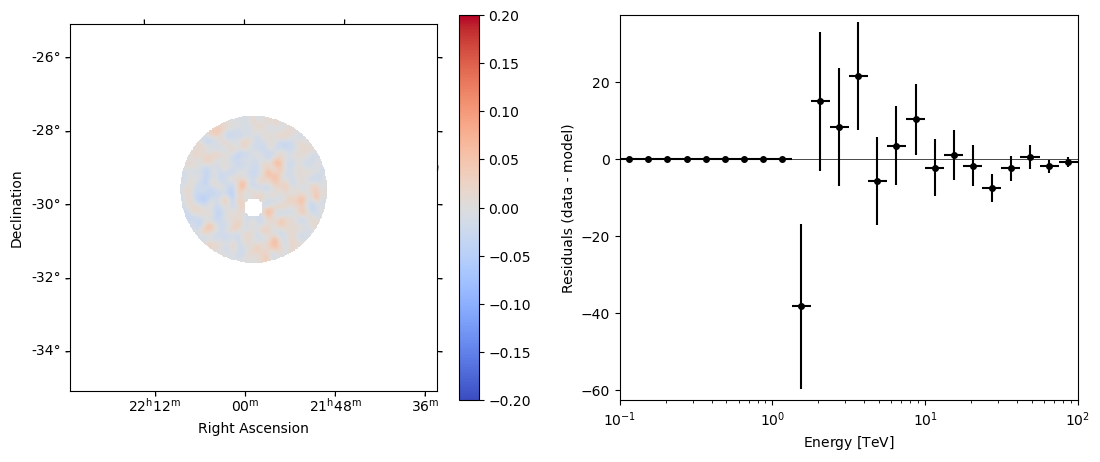

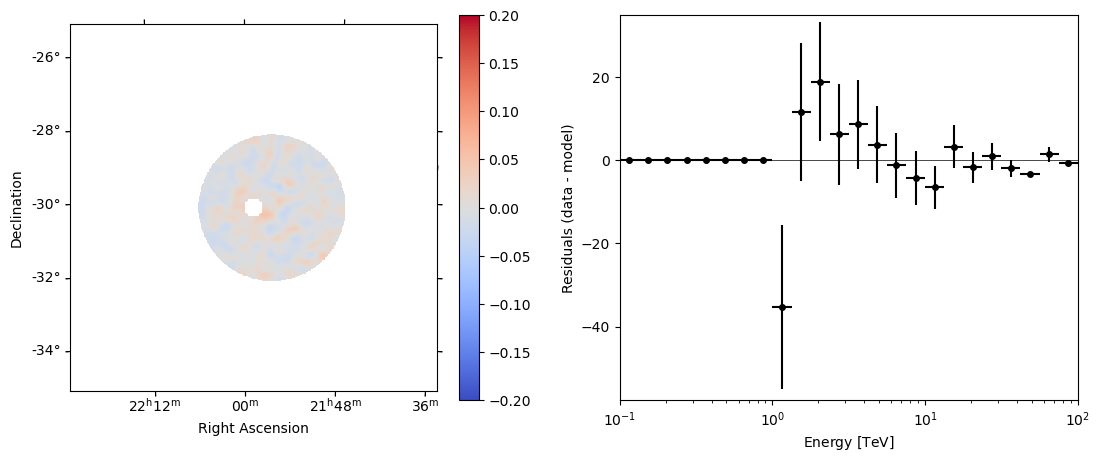

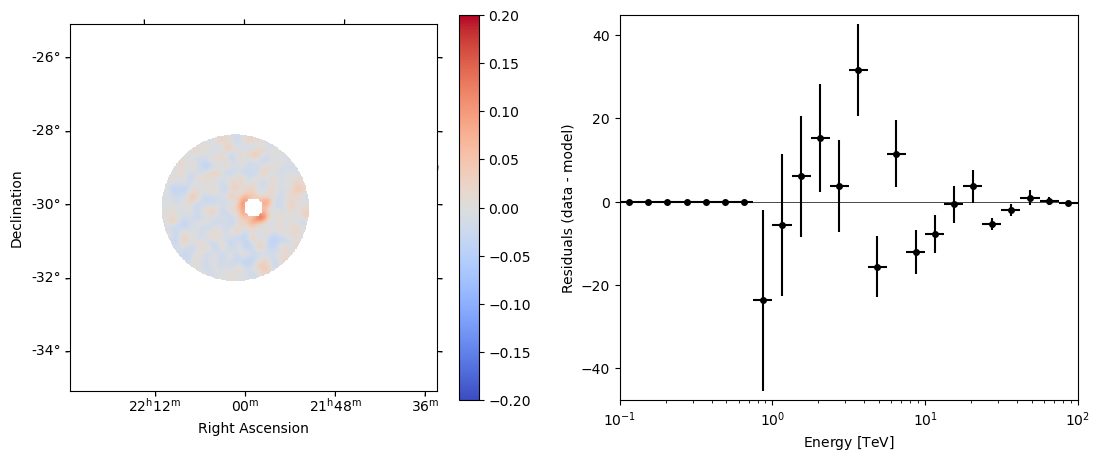

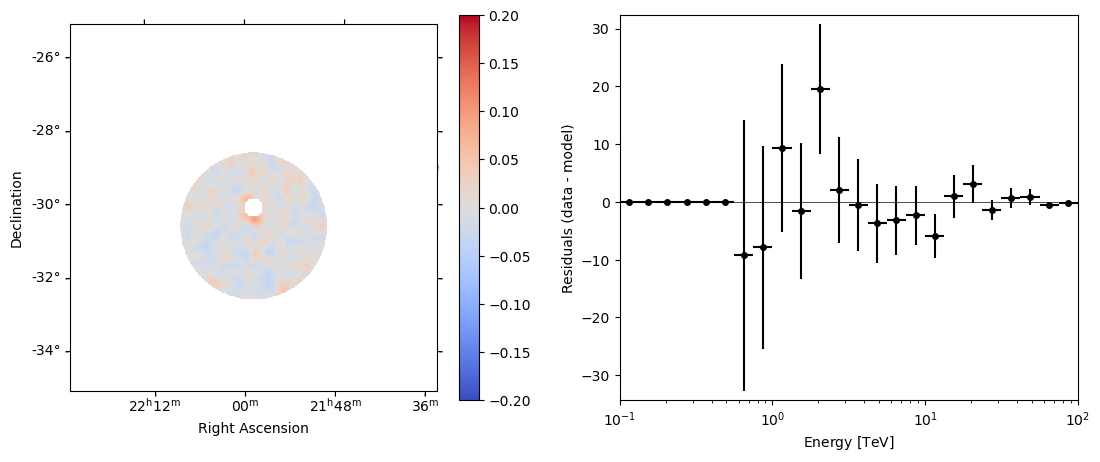

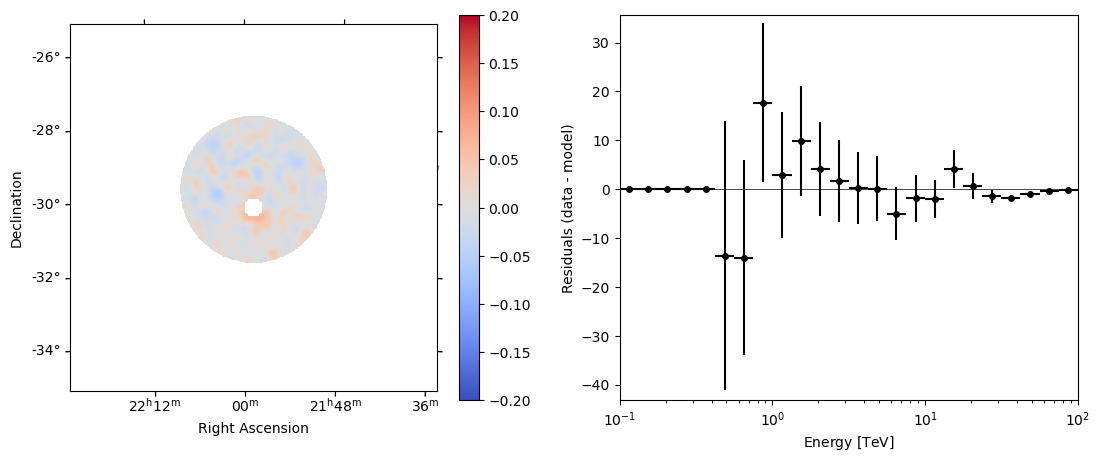

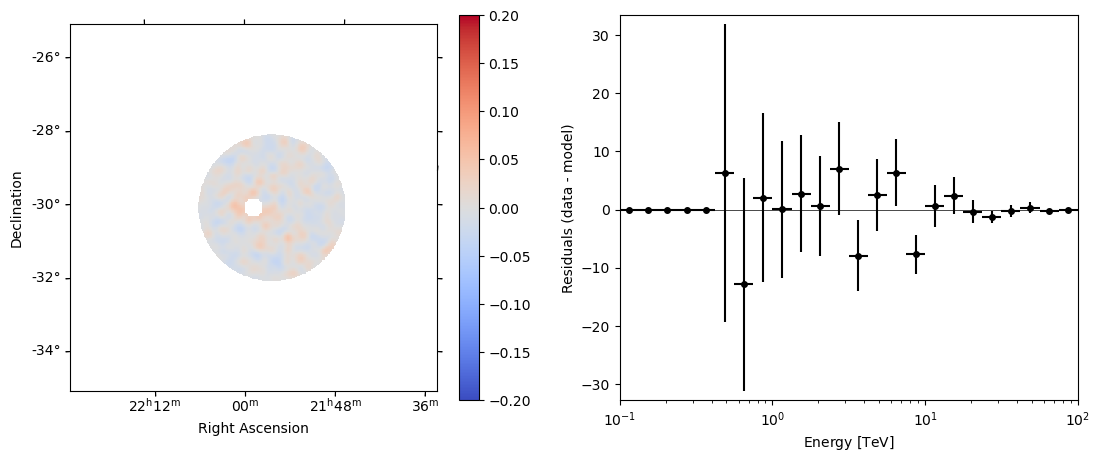

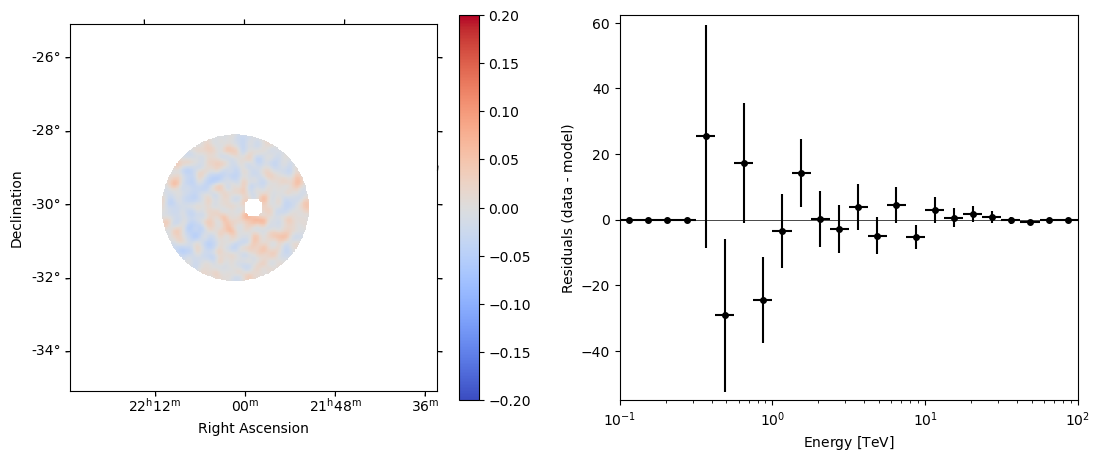

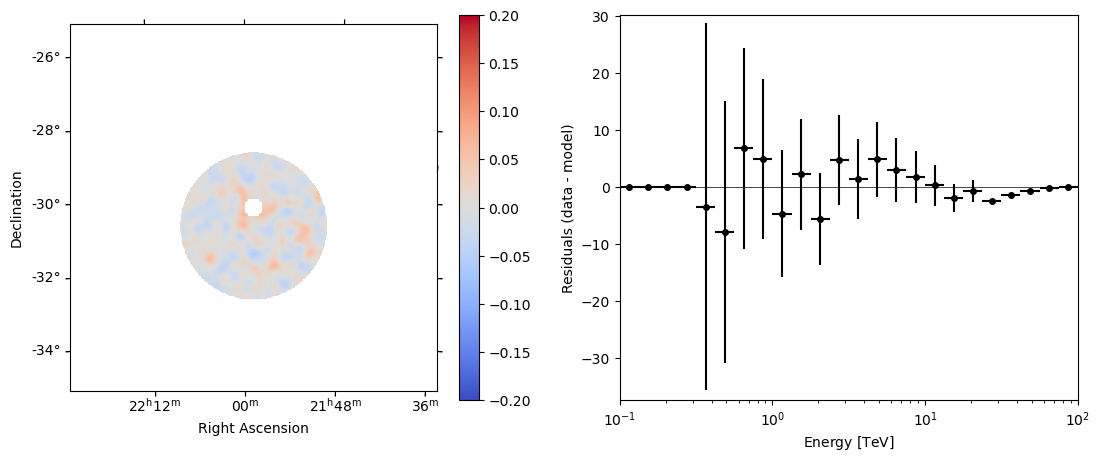

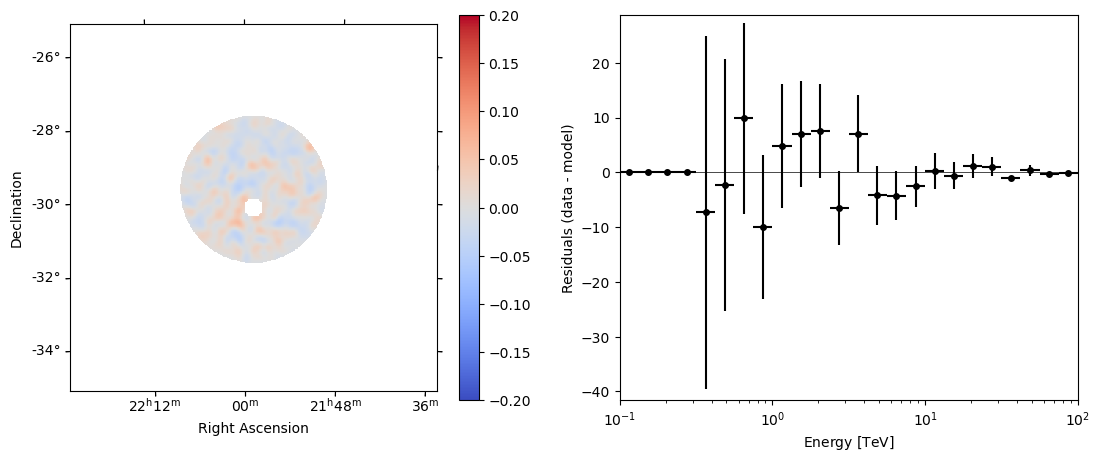

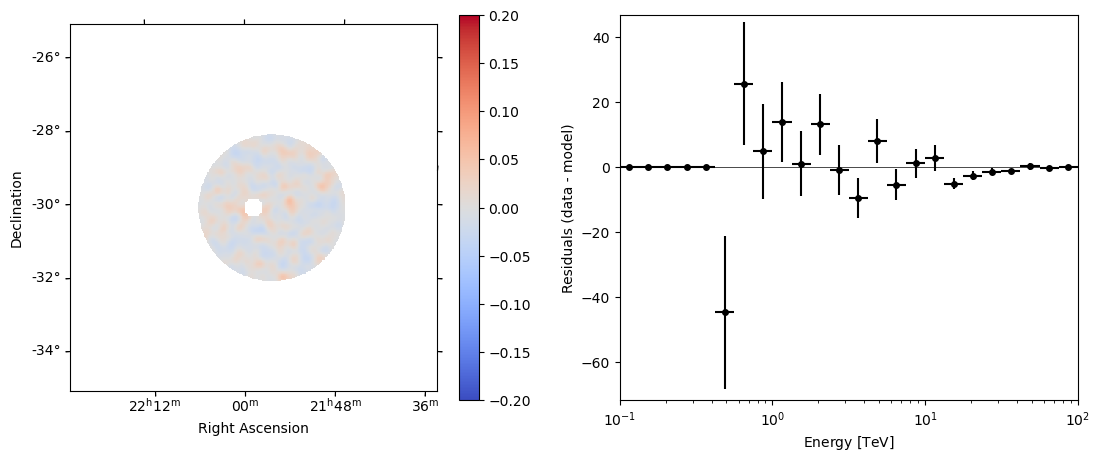

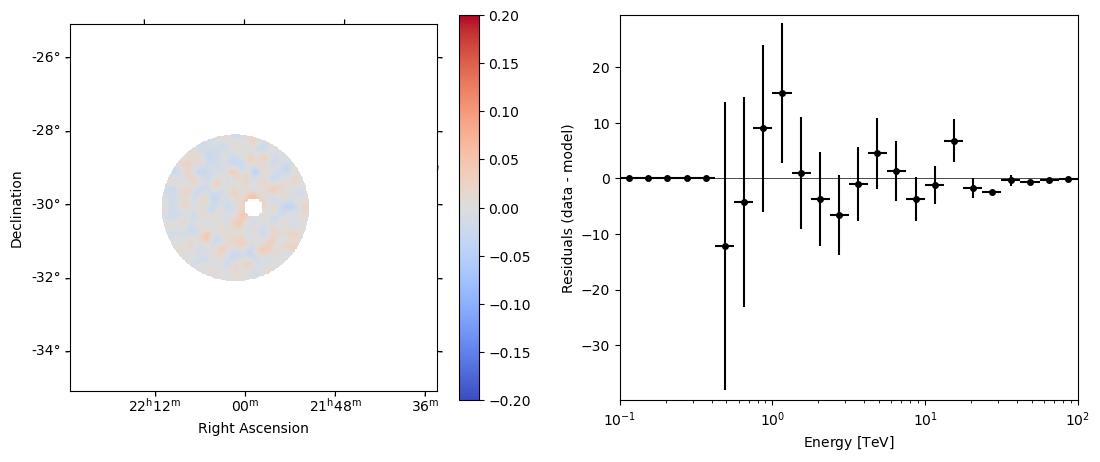

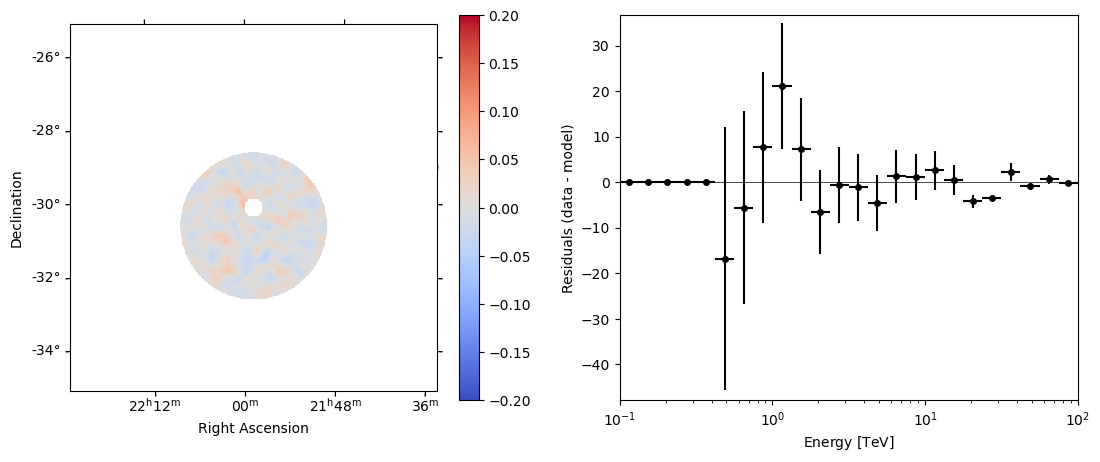

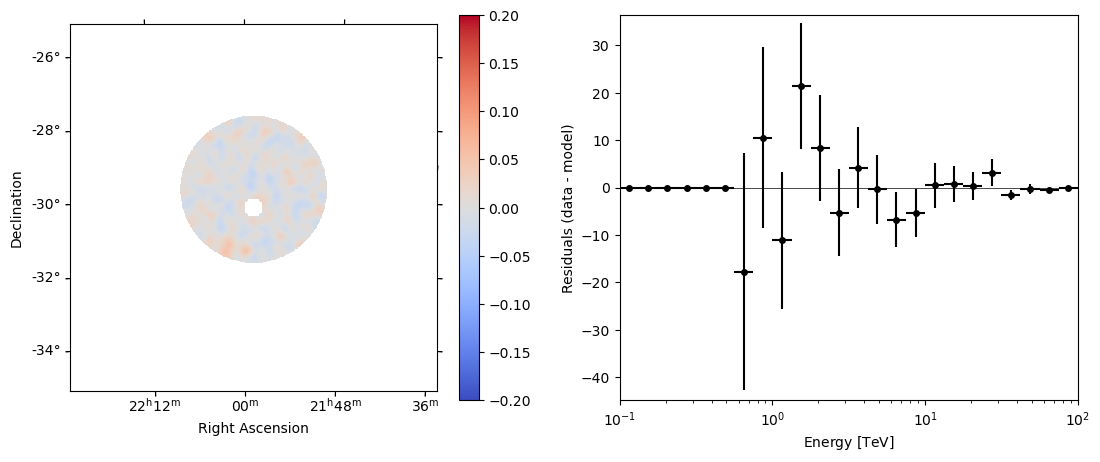

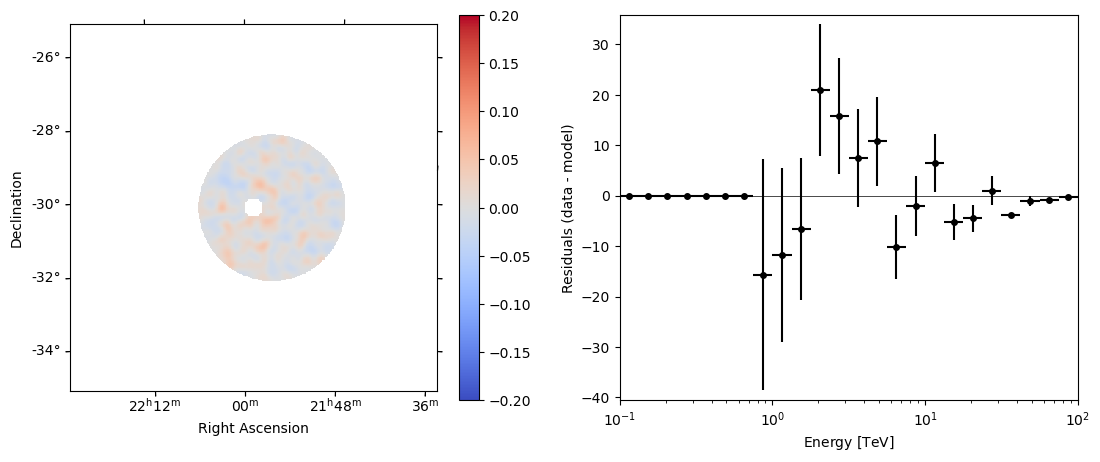

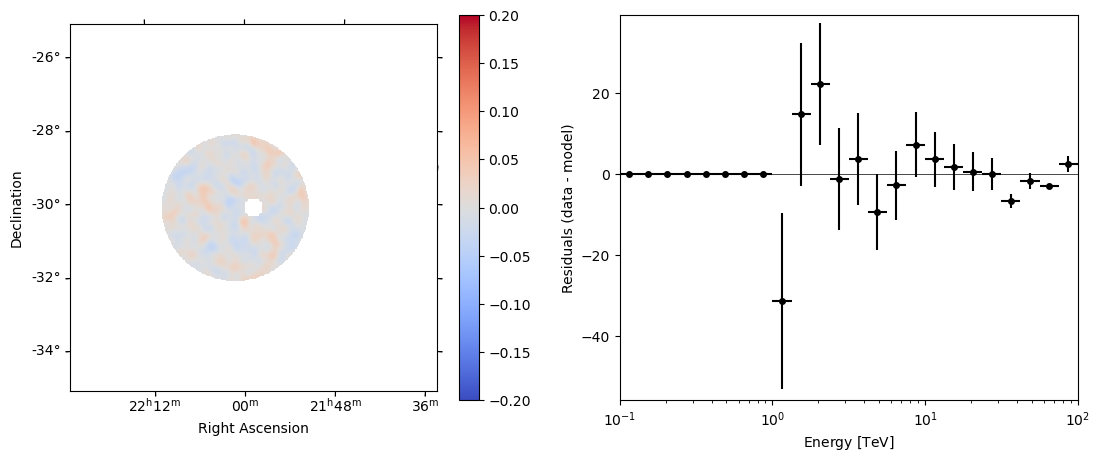

In [19]:

max_offset = 2*u.deg
geom = get_geom()[0]

maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=max_offset)
dataset_stacked = MapDataset.create(geom=geom, name='stacked')

bg_norms_  , bg_tilts_ = [], []

for i,obs in enumerate(observations):
    plt.figure(figsize = (13,5))
    
    reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)    
    dataset = maker.run(reference, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    
    bkg_model = FoVBackgroundModel(dataset_name="{}".format(dataset.name))
    models = Models([bkg_model])
    dataset.models = models
    dataset.background_model.spectral_model.tilt.frozen = False

    dataset.mask_safe.data[:] &= excl_mask_2d.data
    ebins = get_ebins()
    emask = ebins[:-1].value >= maxthreshold[i]
    
    dataset.mask_safe.data[~emask,:,:] = False
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=[dataset])
    print(dataset)
    ax = dataset.plot_residuals(kwargs_spatial = {'vmax': 0.2, 'vmin': -0.2})
    mask_obs_max_offset = geom.to_image().region_mask(
        [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
    )
    dataset.mask_safe.data[emask] = dataset.mask_safe.data[emask] | mask_obs_max_offset

    assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
    dataset.background.data[~dataset.mask_safe.data] = 0.0

    dataset_stacked.stack(dataset)
    # save all datasets
    dataset.write('{}/dataset-obs-{}.fits.gz'.format(path_saving,obs.obs_id), overwrite=True)
    bg_norms, bg_tilts = np.array(dataset.background_model.parameters.value[:2])
    bg_norms_.append(dataset.background_model.parameters['norm'].value)
    bg_tilts_.append(dataset.background_model.parameters['tilt'].value)
    
        
dataset_stacked.write('{}/dataset-stacked.fits.gz'.format(path_saving), overwrite=True)


## Best Fit Results
The BKG normm should be distributed around 1, and the tilt around 0.

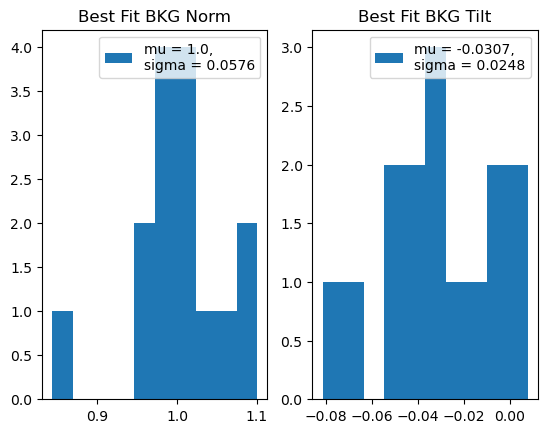

In [20]:
fig,axs = plt.subplots(1,2)
axs[0].hist(bg_norms_, label = f"mu = {np.mean(bg_norms_):.3}, \nsigma = {np.std(bg_norms_):.3}")
axs[1].hist(bg_tilts_, label = f"mu = {np.mean(bg_tilts_):.3}, \nsigma = {np.std(bg_tilts_):.3}")
axs[0].legend();axs[1].legend();
axs[0].set_title("Best Fit BKG Norm")
axs[1].set_title("Best Fit BKG Tilt")

fig.savefig("plots/1-best_fit-bkg.png")


<WCSAxes: >

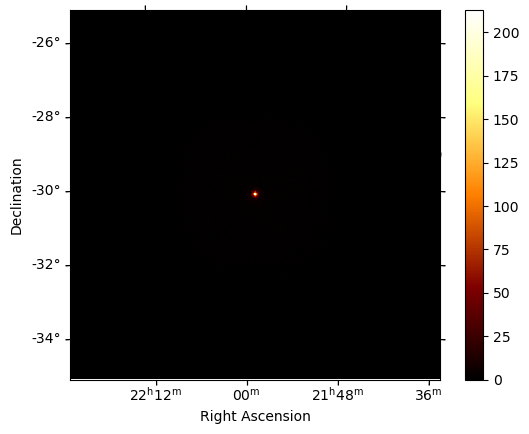

In [21]:
dataset_stacked.counts.sum_over_axes().plot(add_cbar = 1)